In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

companies = pd.read_csv("companies.txt", delimiter="\t", encoding='iso-8859-1')
round2 = pd.read_csv("rounds2.csv", encoding='iso-8859-1')

# Setting the value of key column to lower case to ensure consistency with joining dataframe
companies['permalink'] = companies['permalink'].str.lower()
round2['company_permalink'] = round2['company_permalink'].str.lower()

# Replacing all NaN (Null) values with 0 to ensure that we get consistent aggregations
round2['raised_amount_usd'].fillna(0, inplace=True)

# Table 1.1 outcome
print("\n\nTable 1.1")
print("----------\n")

# Get details of unique companies in companies file
print("Unique values in companies DataFrame :", companies['permalink'].nunique())

# Get details of unique companies in round2
print("Unique values in companies round2 :", round2['company_permalink'].nunique())

# Find out of there are companies in round2 that are not present in companies file

df1 = pd.DataFrame(companies,columns=['permalink'])
df2 = pd.DataFrame(round2,columns=['company_permalink'])

set_diff_df = pd.concat([df1, df2], sort=True).sort_values(['permalink', 'company_permalink']).drop_duplicates(['permalink', 'company_permalink'], keep=False)
print("Additional companies in round2 that does not exist in companies DataFrame :", set_diff_df['company_permalink'].count())

# Merger two data frames
master_frame = pd.merge(round2, companies, how='inner', right_on=['permalink'], left_on=['company_permalink'])
observations = master_frame['company_permalink'].count()

print ("Number of observations in master frame", observations)




Table 1.1
----------

Unique values in companies DataFrame : 66368
Unique values in companies round2 : 66370
Additional companies in round2 that does not exist in companies DataFrame : 42493
Number of observations in master frame 114942


In [2]:
# Table 2.1 outcome
print("\n\nTable 2.1")
print("----------\n")

# Setting display format for float values that are an outcome of groupby
pd.set_option('display.float_format', lambda x: '%.0f' %x)

# Calculate the most representative value of investment amount by funding type = 'VENTURE'
venture_usd = master_frame[master_frame['funding_round_type'] == 'venture'].groupby('funding_round_type')['raised_amount_usd'].mean()
print ("Investment amount by funding type as 'VENTURE'        = ", '%.0f' % venture_usd)

# Calculate the most representative value of investment amount by funding type = 'ANGEL'
angel_usd = master_frame[master_frame['funding_round_type'] == 'angel'].groupby('funding_round_type')['raised_amount_usd'].mean()
print ("Investment amount by funding type as 'ANGEL'          = ", '%.0f' % angel_usd)

# Calculate the most representative value of investment amount by funding type = 'SEED'
seed_usd = master_frame[master_frame['funding_round_type'] == 'seed'].groupby('funding_round_type')['raised_amount_usd'].mean()
print ("Investment amount by funding type as 'SEED'           = ", '%.0f' % seed_usd)

# Calculate the most representative value of investment amount by funding type = 'PRIVATE EQUITY'
private_equity_usd = master_frame[master_frame['funding_round_type'] == 'private_equity'].groupby('funding_round_type')['raised_amount_usd'].mean()
print ("Investment amount by funding type as 'PRIVATE EQUITY' = ", '%.0f' % private_equity_usd)



Table 2.1
----------

Investment amount by funding type as 'VENTURE'        =  10634246
Investment amount by funding type as 'ANGEL'          =  764564
Investment amount by funding type as 'SEED'           =  556663
Investment amount by funding type as 'PRIVATE EQUITY' =  62111788


In [3]:
# Table 3.1 outcome
print("\n\nTable 3.1")
print("----------\n")

# Create a copy of master frame to be used for Plot creation in 6.1
master_frame_base = master_frame.copy()

#For the chosen investment type, make a data frame named top9 with the top nine countries
master_frame = master_frame[master_frame['funding_round_type'] == 'venture']

top9 = master_frame.groupby('country_code').sum()

pd.set_option('display.float_format', lambda x: '%.f' %x)
print(top9['raised_amount_usd'].nlargest(9))



Table 3.1
----------

country_code
USA   422510842796
CHN    39835418773
GBR    20245627416
IND    14391858718
CAN     9583332317
FRA     7259536732
ISR     6907514579
DEU     6346959822
JPN     3363676611
Name: raised_amount_usd, dtype: float64


In [4]:
# Table 4.1 outcome
print("\n\nTable 4.1")
print("----------\n")

# Splitting category list to extract primary sector into a new column 
new_column = master_frame['category_list'].str.split('|', n=1, expand=True)
master_frame['primary_sector'] = new_column[0]

# Load mapping file
mappings = pd.read_csv("mapping.csv", delimiter=",", encoding='iso-8859-1')

master_frame['primary_sector'].fillna(0, inplace=True)
mappings['category_list'].fillna(0, inplace=True)
mappings = mappings.replace('A0lytic.+', value='Analytics',regex=True)

# Map each primary sector mapped to its main sector 
master_frame_mapping = pd.merge(master_frame, mappings, how='left', left_on=['primary_sector'], right_on=['category_list'])




Table 4.1
----------



In [5]:
print("\n\nTable 5.1")
print("----------\n")
print("\n\nFunding type = 'venture' and Country='USA'\n")

# Filter data for Country1 and Investment Type between 5 and 15 Mil
D1 = master_frame_mapping[(master_frame_mapping['funding_round_type'] == 'venture') & \
                          (master_frame_mapping['country_code'] == 'USA')]

# total number (or count) of investments for each main sector in a separate column
d1group = (D1.groupby('primary_sector')
        .agg({'raised_amount_usd':'sum',
              'Automotive & Sports':'sum',
              'Blanks':'sum',
              'Cleantech / Semiconductors':'sum',
              'Entertainment':'sum',
              'Health':'sum',
              'Manufacturing':'sum',
              'News, Search and Messaging':'sum', 
              'Others':'sum',
              'Social, Finance, Analytics, Advertising':'sum'})
        .reset_index()
        .rename(columns={'Automotive & Sports':'Automotive & Sports Count',
                         'Blanks':'Blanks Count',
                         'Cleantech / Semiconductors':'Cleantech / Semiconductors Count',
                         'Entertainment':'Entertainment Count',
                         'Health':'Health Count',
                         'Manufacturing':'Manufacturing Count',
                         'News, Search and Messaging':'News, Search and Messaging Count', 
                         'Others':'Others Count',
                         'Social, Finance, Analytics, Advertising':'Social, Finance, Analytics, Advertising Count'}))

d1_total_investment_count = d1group['Automotive & Sports Count'].sum() + \
                            d1group['Blanks Count'].sum() + \
                            d1group['Cleantech / Semiconductors Count'].sum() + \
                            d1group['Entertainment Count'].sum() + \
                            d1group['Health Count'].sum() + \
                            d1group['Manufacturing Count'].sum() + \
                            d1group['News, Search and Messaging Count'].sum() + \
                            d1group['Others Count'].sum() + \
                            d1group['Social, Finance, Analytics, Advertising Count'].sum()

print("Total number of investments (count) : ", '%.0f' % d1_total_investment_count)

#Total amount invested in each main sector in a separate column
d1_total_investment_usd = d1group.raised_amount_usd.sum()
print("Total amount of investment (USD) : ", '%.0f' % d1_total_investment_usd)

# Top sectors (based on count of investments)
df_investment1 = pd.DataFrame({'Automotive & Sports Count':d1group['Automotive & Sports Count'].sum(),\
                                'Blanks Count':d1group['Blanks Count'].sum(),\
                                'Cleantech / Semiconductors Count':d1group['Cleantech / Semiconductors Count'].sum(),\
                                'Entertainment Count':d1group['Entertainment Count'].sum(),\
                                'Health Count':d1group['Health Count'].sum(),\
                                'Manufacturing Count':d1group['Manufacturing Count'].sum(),\
                                'News, Search and Messaging Count':d1group['News, Search and Messaging Count'].sum(),\
                                'Others Count':d1group['Others Count'].sum(),\
                                'Social, Finance, Analytics, Advertising Count':d1group['Social, Finance, Analytics, Advertising Count'].sum()},index=[0])

print("\n\nTop 3 Sectors and number of investments within each of them\n")
print(pd.DataFrame(df_investment1.max().sort_values(ascending=False)).head(3))

# Build dataframe for usage in final graph expected in 6.3
usaDF = pd.DataFrame(df_investment1.max().sort_values(ascending=False)).reset_index()

d1_main_sector_others = D1[D1['Others'] == 1]
d1_main_sector_cleantech = D1[D1['Cleantech / Semiconductors'] == 1]
d1_main_sector_social = D1[D1['Social, Finance, Analytics, Advertising'] == 1]

# Create data for Graph to be plotted in section 6 using count and amount invested
data = {'country_code': ['USA','USA','USA'], 
        'main_sector': [usaDF.iloc[0,0], usaDF.iloc[1,0], usaDF.iloc[2,0]], 
        'investment_count': [usaDF.iloc[0,1], usaDF.iloc[1,1], usaDF.iloc[2,1]],
        'investment_amt': [d1_main_sector_others['raised_amount_usd'].sum(), \
                           d1_main_sector_cleantech['raised_amount_usd'].sum(), \
                           d1_main_sector_social['raised_amount_usd'].sum()]} 
  
# Convert the dictionary into DataFrame 
usa_DF = pd.DataFrame(data) 

# For the top sector count-wise (point 3), which company received the highest investment
d1company1 = D1[D1['Others'] == 1]
c1 = d1company1.groupby('permalink').agg({'raised_amount_usd':sum}).nlargest(1, 'raised_amount_usd')
print("\n\nFor point 3 (top sector count-wise), which company received the highest investment\n")
print(c1)

# For the second-best sector count-wise (point 4), which company received the highest investment
d1company2 = D1[D1['Cleantech / Semiconductors'] == 1]
c2 = d1company2.groupby('permalink').agg({'raised_amount_usd':sum}).nlargest(1, 'raised_amount_usd')
print("\n\nFor point 4 (second best sector count-wise), which company received the highest investment\n")
print(c2)




Table 5.1
----------



Funding type = 'venture' and Country='USA'

Total number of investments (count) :  37248
Total amount of investment (USD) :  422510842796


Top 3 Sectors and number of investments within each of them

                                                 0
Others Count                                  8693
Cleantech / Semiconductors Count              8113
Social, Finance, Analytics, Advertising Count 7042


For point 3 (top sector count-wise), which company received the highest investment

                              raised_amount_usd
permalink                                      
/organization/social-finance         1365199900


For point 4 (second best sector count-wise), which company received the highest investment

                         raised_amount_usd
permalink                                 
/organization/freescale        17600000000


In [6]:
print("\n\nFunding type = 'venture' and Country='GBR'\n\n")

# Filter data for Country1 and Investment Type between 5 and 15 Mil
D2 = master_frame_mapping[(master_frame_mapping['funding_round_type'] == 'venture') & \
                          (master_frame_mapping['country_code'] == 'GBR')]

# total number (or count) of investments for each main sector in a separate column
d2group = (D2.groupby('primary_sector')
        .agg({'raised_amount_usd':'sum',
              'Automotive & Sports':'sum',
              'Blanks':'sum',
              'Cleantech / Semiconductors':'sum',
              'Entertainment':'sum',
              'Health':'sum',
              'Manufacturing':'sum',
              'News, Search and Messaging':'sum', 
              'Others':'sum',
              'Social, Finance, Analytics, Advertising':'sum'})
        .reset_index()
        .rename(columns={'Automotive & Sports':'Automotive & Sports Count',
                         'Blanks':'Blanks Count',
                         'Cleantech / Semiconductors':'Cleantech / Semiconductors Count',
                         'Entertainment':'Entertainment Count',
                         'Health':'Health Count',
                         'Manufacturing':'Manufacturing Count',
                         'News, Search and Messaging':'News, Search and Messaging Count', 
                         'Others':'Others Count',
                         'Social, Finance, Analytics, Advertising':'Social, Finance, Analytics, Advertising Count'}))

d2_total_investment_count = d2group['Automotive & Sports Count'].sum() + \
                            d2group['Blanks Count'].sum() + \
                            d2group['Cleantech / Semiconductors Count'].sum() + \
                            d2group['Entertainment Count'].sum() + \
                            d2group['Health Count'].sum() + \
                            d2group['Manufacturing Count'].sum() + \
                            d2group['News, Search and Messaging Count'].sum() + \
                            d2group['Others Count'].sum() + \
                            d2group['Social, Finance, Analytics, Advertising Count'].sum()

print("Total number of investments (count) : ", '%.0f' % d2_total_investment_count)

#Total amount invested in each main sector in a separate column
d2_total_investment_usd = d2group.raised_amount_usd.sum()
print("Total amount of investment (USD) : ", '%.0f' % d2_total_investment_usd)

# Top sectors (based on count of investments)
df_investment2 = pd.DataFrame({'Automotive & Sports Count':d2group['Automotive & Sports Count'].sum(),\
                              'Blanks Count':d2group['Blanks Count'].sum(),\
                              'Cleantech / Semiconductors Count':d2group['Cleantech / Semiconductors Count'].sum(),\
                              'Entertainment Count':d2group['Entertainment Count'].sum(),\
                              'Health Count':d2group['Health Count'].sum(),\
                              'Manufacturing Count':d2group['Manufacturing Count'].sum(),\
                              'News, Search and Messaging Count':d2group['News, Search and Messaging Count'].sum(),\
                              'Others Count':d2group['Others Count'].sum(),\
                              'Social, Finance, Analytics, Advertising Count':d2group['Social, Finance, Analytics, Advertising Count'].sum()},index=[0])

print("\n\nTop 3 Sectors and number of investments within each of them\n")
print(pd.DataFrame(df_investment2.max().sort_values(ascending=False)).head(3))

# Build dataframe for usage in final graph expected in 6.3
gbrDF = pd.DataFrame(df_investment2.max().sort_values(ascending=False)).reset_index()

d1_main_sector_others = D2[D2['Others'] == 1]
d1_main_sector_cleantech = D2[D2['Cleantech / Semiconductors'] == 1]
d1_main_sector_social = D2[D2['Social, Finance, Analytics, Advertising'] == 1]

# Create data for Graph to be plotted in section 6 using count and amount invested
data = {'country_code': ['GBR','GBR','GBR'], 
        'main_sector': [gbrDF.iloc[0,0], gbrDF.iloc[1,0], gbrDF.iloc[2,0]], 
        'investment_count': [gbrDF.iloc[0,1], gbrDF.iloc[1,1], gbrDF.iloc[2,1]],
        'investment_amt': [d1_main_sector_others['raised_amount_usd'].sum(), \
                           d1_main_sector_cleantech['raised_amount_usd'].sum(), \
                           d1_main_sector_social['raised_amount_usd'].sum()]} 
  
# Convert the dictionary into DataFrame 
gbr_DF = pd.DataFrame(data) 

# For the top sector count-wise (point 3), which company received the highest investment
d2company1 = D2[D2['Others'] == 1]
d2c1 = d2company1.groupby('permalink').agg({'raised_amount_usd':sum}).nlargest(1, 'raised_amount_usd')
print("\n\nFor point 3 (top sector count-wise), which company received the highest investment\n")
print(d2c1)

# For the second-best sector count-wise (point 4), which company received the highest investment
d2company2 = D2[D2['Cleantech / Semiconductors'] == 1]
d2c2 = d2company2.groupby('permalink').agg({'raised_amount_usd':sum}).nlargest(1, 'raised_amount_usd')
print("\n\nFor point 4 (second best sector count-wise), which company received the highest investment\n")
print(d2c2)




Funding type = 'venture' and Country='GBR'


Total number of investments (count) :  2207
Total amount of investment (USD) :  20245627416


Top 3 Sectors and number of investments within each of them

                                                0
Others Count                                  571
Cleantech / Semiconductors Count              456
Social, Finance, Analytics, Advertising Count 408


For point 3 (top sector count-wise), which company received the highest investment

                      raised_amount_usd
permalink                              
/organization/oneweb          500000000


For point 4 (second best sector count-wise), which company received the highest investment

                          raised_amount_usd
permalink                                  
/organization/immunocore          320000000


In [7]:
print("\n\nFunding type = 'venture' and Country='IND'\n\n")

# Filter data for Country1 and Investment Type between 5 and 15 Mil
D3 = master_frame_mapping[(master_frame_mapping['funding_round_type'] == 'venture') & \
                          (master_frame_mapping['country_code'] == 'IND')]

# total number (or count) of investments for each main sector in a separate column
d3group = (D3.groupby('primary_sector')
        .agg({'raised_amount_usd':'sum',
              'Automotive & Sports':'sum',
              'Blanks':'sum',
              'Cleantech / Semiconductors':'sum',
              'Entertainment':'sum',
              'Health':'sum',
              'Manufacturing':'sum',
              'News, Search and Messaging':'sum', 
              'Others':'sum',
              'Social, Finance, Analytics, Advertising':'sum'})
        .reset_index()
        .rename(columns={'Automotive & Sports':'Automotive & Sports Count',
                         'Blanks':'Blanks Count',
                         'Cleantech / Semiconductors':'Cleantech / Semiconductors Count',
                         'Entertainment':'Entertainment Count',
                         'Health':'Health Count',
                         'Manufacturing':'Manufacturing Count',
                         'News, Search and Messaging':'News, Search and Messaging Count', 
                         'Others':'Others Count',
                         'Social, Finance, Analytics, Advertising':'Social, Finance, Analytics, Advertising Count'}))

d3_total_investment_count = d3group['Automotive & Sports Count'].sum() + \
                            d3group['Blanks Count'].sum() + \
                            d3group['Cleantech / Semiconductors Count'].sum() + \
                            d3group['Entertainment Count'].sum() + \
                            d3group['Health Count'].sum() + \
                            d3group['Manufacturing Count'].sum() + \
                            d3group['News, Search and Messaging Count'].sum() + \
                            d3group['Others Count'].sum() + \
                            d3group['Social, Finance, Analytics, Advertising Count'].sum()

print("Total number of investments (count) : ", '%.0f' % d3_total_investment_count)

#Total amount invested in each main sector in a separate column
d3_total_investment_usd = d3group.raised_amount_usd.sum()
print("Total amount of investment (USD) : ", '%.0f' % d3_total_investment_usd)

# Top sectors (based on count of investments)
df_investment3 = pd.DataFrame({'Automotive & Sports Count':d3group['Automotive & Sports Count'].sum(),\
                              'Blanks Count':d3group['Blanks Count'].sum(),\
                              'Cleantech / Semiconductors Count':d3group['Cleantech / Semiconductors Count'].sum(),\
                              'Entertainment Count':d3group['Entertainment Count'].sum(),\
                              'Health Count':d3group['Health Count'].sum(),\
                              'Manufacturing Count':d3group['Manufacturing Count'].sum(),\
                              'News, Search and Messaging Count':d3group['News, Search and Messaging Count'].sum(),\
                              'Others Count':d3group['Others Count'].sum(),\
                              'Social, Finance, Analytics, Advertising Count':d3group['Social, Finance, Analytics, Advertising Count'].sum()},index=[0])

print("\n\nTop 3 Sectors and number of investments within each of them\n")
print(pd.DataFrame(df_investment3.max().sort_values(ascending=False)).head(3))

# Build dataframe for usage in final graph expected in 6.3
indDF = pd.DataFrame(df_investment3.max().sort_values(ascending=False)).reset_index()

d1_main_sector_others = D3[D3['Others'] == 1]
d1_main_sector_news = D3[D3['News, Search and Messaging'] == 1]
d1_main_sector_social = D3[D3['Social, Finance, Analytics, Advertising'] == 1]

# Create data for Graph to be plotted in section 6 using count and amount invested
data = {'country_code': ['IND','IND','IND'], 
        'main_sector': [indDF.iloc[0,0], indDF.iloc[1,0], indDF.iloc[2,0]], 
        'investment_count': [indDF.iloc[0,1], indDF.iloc[1,1], indDF.iloc[2,1]],
        'investment_amt': [d1_main_sector_others['raised_amount_usd'].sum(), \
                           d1_main_sector_news['raised_amount_usd'].sum(), \
                           d1_main_sector_social['raised_amount_usd'].sum()]} 
  
# Convert the dictionary into DataFrame 
ind_DF = pd.DataFrame(data) 

# For the top sector count-wise (point 3), which company received the highest investment
d3company1 = D3[D3['Others'] == 1]
d3c1 = d3company1.groupby('permalink').agg({'raised_amount_usd':sum}).nlargest(1, 'raised_amount_usd')
print("\n\nFor point 3 (top sector count-wise), which company received the highest investment\n")
print(d3c1)

# For the second-best sector count-wise (point 4), which company received the highest investment
d3company2 = D3[D3['News, Search and Messaging'] == 1]
d3c2 = d3company2.groupby('permalink').agg({'raised_amount_usd':sum}).nlargest(1, 'raised_amount_usd')
print("\n\nFor point 4 (second best sector count-wise), which company received the highest investment\n")
print(d3c2)



Funding type = 'venture' and Country='IND'


Total number of investments (count) :  927
Total amount of investment (USD) :  14391858718


Top 3 Sectors and number of investments within each of them

                                                0
Others Count                                  329
News, Search and Messaging Count              154
Social, Finance, Analytics, Advertising Count 133


For point 3 (top sector count-wise), which company received the highest investment

                        raised_amount_usd
permalink                                
/organization/flipkart         2451000000


For point 4 (second best sector count-wise), which company received the highest investment

                           raised_amount_usd
permalink                                   
/organization/quikr-india          346000000




Plot 6.1
----------



<Figure size 432x288 with 0 Axes>

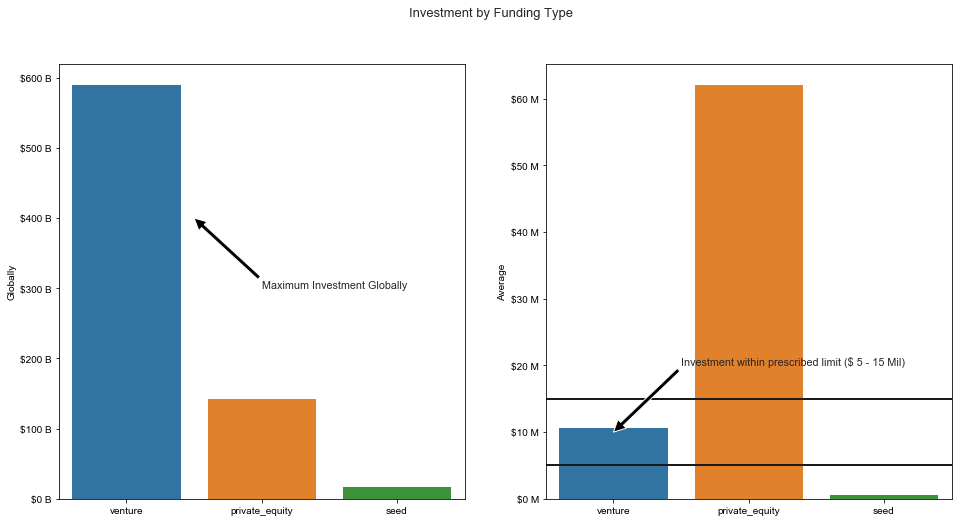

In [10]:
# Table 6.1 outcome
print("\n\nPlot 6.1")
print("----------\n")

from matplotlib.ticker import FuncFormatter

# create a dataframe to be used for plotting investment by fund type
plot1df = master_frame_base[(master_frame_base['funding_round_type'] == 'venture') | \
                           (master_frame_base['funding_round_type'] == 'seed')    | \
                           (master_frame_base['funding_round_type'] == 'private_equity')]

global_investment = plot1df.groupby('funding_round_type').sum().sort_values(by='raised_amount_usd', ascending=False).reset_index()
average_investment = plot1df.groupby('funding_round_type').mean().sort_values(by='raised_amount_usd', ascending=False).reset_index()

investment_by_ft = pd.merge(global_investment, average_investment, how='inner', \
                            left_on='funding_round_type', right_on='funding_round_type', \
                            suffixes=('_global','_average'))

# Create two sub plots - one for Global investments and second for average investments
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

sns.barplot(investment_by_ft['funding_round_type'].values, investment_by_ft['raised_amount_usd_global'].values, ax=ax1)
sns.barplot(investment_by_ft['funding_round_type'].values, investment_by_ft['raised_amount_usd_average'].values, ax=ax2)

sns.set(style='darkgrid', palette='deep', font='sans-serif', font_scale=.9, color_codes=True, rc=None)

# Setting up title, axis lables and formatting the display of axis values
fig.suptitle("Investment by Funding Type")
ax1.set_ylabel("Globally")
ax2.set_ylabel("Average")

def billions(x, pos):
    return '$%.0f B' % (x*1e-9)


def millions(x, pos):
    return '$%.0f M' % (x*1e-6)


formatter = FuncFormatter(billions)
ax1.yaxis.set_major_formatter(formatter)

formatter = FuncFormatter(millions)
ax2.yaxis.set_major_formatter(formatter)

# Add labels to the plot
ax1.annotate('Maximum Investment Globally', xy=(0.5, 4e+11), xytext=(1, 3e+11),
            arrowprops=dict(facecolor='black', shrink=2))

# Add labels to the plot
ax2.annotate('Investment within prescribed limit ($ 5 - 15 Mil)', xy=(0, 10e+6), xytext=(.5, 20e+6),
            arrowprops=dict(facecolor='black', shrink=2))

plt.axhline(y=5000000, linewidth=2, color = 'k')
plt.axhline(y=15000000, linewidth=2, color = 'k')

plt.savefig('Investment_By_Funding_Type.png')



Plot 6.2
----------



<Figure size 432x288 with 0 Axes>

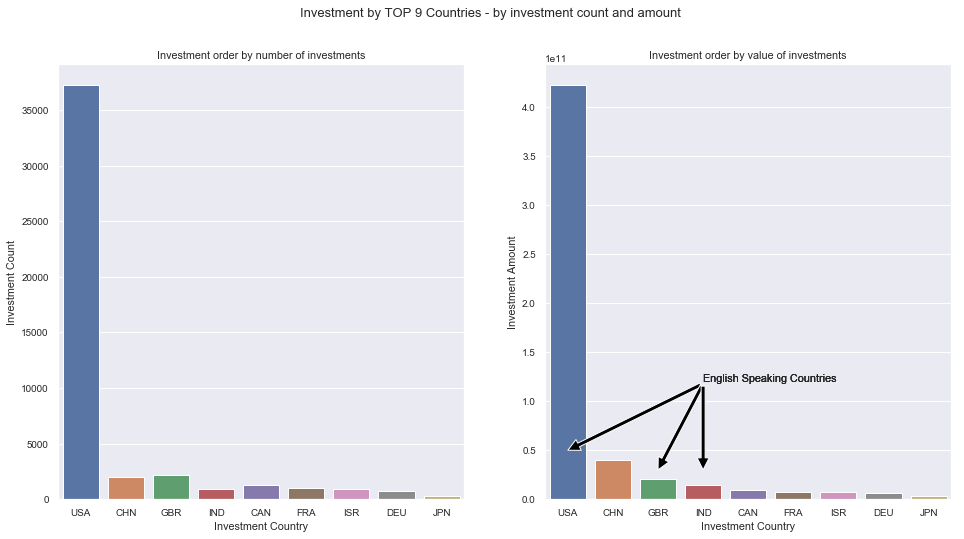

In [11]:
# Table 6.2 outcome
print("\n\nPlot 6.2")
print("----------\n")

#For the chosen investment type, make a data frame named top9 with the top nine countries

df_venture = master_frame_mapping[master_frame_mapping['funding_round_type'] == 'venture']

df_top9 = (df_venture.groupby('country_code')
        .agg({'raised_amount_usd':'sum',
              'Automotive & Sports':'sum',
              'Blanks':'sum',
              'Cleantech / Semiconductors':'sum',
              'Entertainment':'sum',
              'Health':'sum',
              'Manufacturing':'sum',
              'News, Search and Messaging':'sum', 
              'Others':'sum',
              'Social, Finance, Analytics, Advertising':'sum'})
        .reset_index()
        .rename(columns={'Automotive & Sports':'Automotive & Sports Count',
                         'Blanks':'Blanks Count',
                         'Cleantech / Semiconductors':'Cleantech / Semiconductors Count',
                         'Entertainment':'Entertainment Count',
                         'Health':'Health Count',
                         'Manufacturing':'Manufacturing Count',
                         'News, Search and Messaging':'News, Search and Messaging Count', 
                         'Others':'Others Count',
                         'Social, Finance, Analytics, Advertising':'Social, Finance, Analytics, Advertising Count'})
        .nlargest(9, 'raised_amount_usd'))

df_top9['investment_count'] = df_top9['Automotive & Sports Count'] + \
                            df_top9['Blanks Count'] + \
                            df_top9['Cleantech / Semiconductors Count'] + \
                            df_top9['Entertainment Count'] + \
                            df_top9['Health Count'] + \
                            df_top9['Manufacturing Count'] + \
                            df_top9['News, Search and Messaging Count'] + \
                            df_top9['Others Count'] + \
                            df_top9['Social, Finance, Analytics, Advertising Count']


# Create two sub plots - one for Global investments and second for average investments
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# Setting up title, axis lables and formatting the display of axis values
fig.suptitle("Investment by TOP 9 Countries - by investment count and amount")

sns.barplot(df_top9['country_code'].values, df_top9['investment_count'].values, ax=ax1)
ax1.set_title("Investment order by number of investments")
ax1.set_ylabel("Investment Count")
ax1.set_xlabel("Investment Country")


sns.barplot(x="country_code", y="raised_amount_usd", data=df_top9, estimator=sum)
ax2.set_title("Investment order by value of investments")
ax2.set_ylabel("Investment Amount")
ax2.set_xlabel("Investment Country")


# Add labels to the plot
ax2.annotate('English Speaking Countries', xy=(0, 5e+10), xytext=(3, 12e+10),
            arrowprops=dict(facecolor='black', shrink=2))
ax2.annotate('English Speaking Countries', xy=(2, 3e+10), xytext=(3, 12e+10),
            arrowprops=dict(facecolor='black', shrink=2))
ax2.annotate('English Speaking Countries', xy=(3, 3e+10), xytext=(3, 12e+10),
            arrowprops=dict(facecolor='black', shrink=2))

plt.savefig('Investment_By_top9_Countries.png')



Plot 6.3
----------



<Figure size 432x288 with 0 Axes>

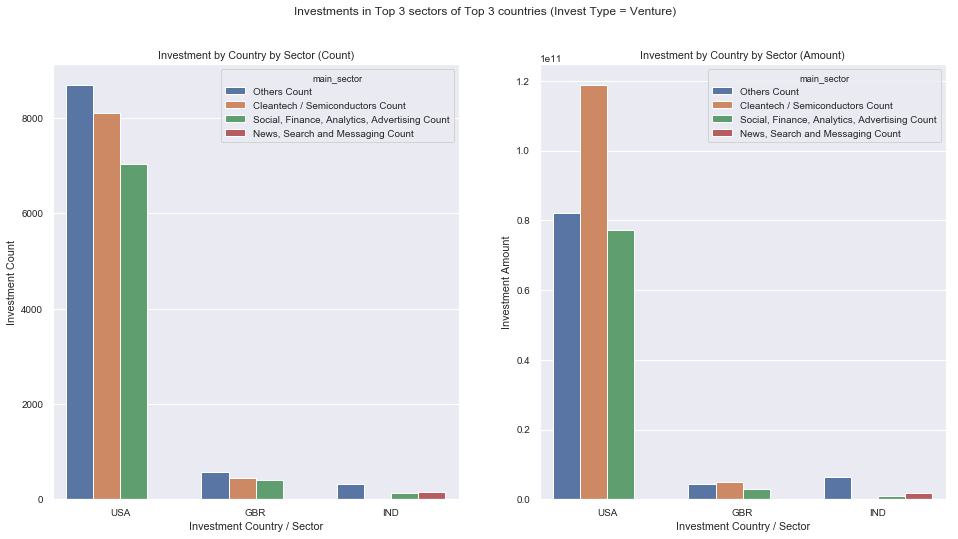

In [30]:
# Plot 6.3 outcome
print("\n\nPlot 6.3")
print("----------\n")

#For the chosen investment type, make a data frame with top 3 sectors of top 3 countries

frames = [usa_DF, gbr_DF, ind_DF]
df_country_sector = pd.concat(frames)

# Create two sub plots - one for Investments by Sector (count) and Investment by sector (Amount)
fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# Setting up title, axis lables and formatting the display of axis values
fig.suptitle("Investments in Top 3 sectors of Top 3 countries (Invest Type = Venture)")

sns.barplot(df_country_sector['country_code'].values, df_country_sector['investment_count'].values,\
            hue=df_country_sector['main_sector'], ax=ax1)
ax1.set_title("Investment by Country by Sector (Count)")
ax1.set_ylabel("Investment Count")
ax1.set_xlabel("Investment Country / Sector")

sns.barplot(df_country_sector['country_code'].values, df_country_sector['investment_amt'].values,\
            hue=df_country_sector['main_sector'], ax=ax2)
ax2.set_title("Investment by Country by Sector (Amount)")
ax2.set_ylabel("Investment Amount")
ax2.set_xlabel("Investment Country / Sector")

plt.savefig('Investment_By_top3_Countries_Sectors.png')